In [1]:
#!pip install pyspark

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.regression import DecisionTreeRegressor, DecisionTreeRegressionModel

from pyspark.ml.feature import VectorAssembler


from dtreeviz.models.spark_decision_tree import ShadowSparkTree
from dtreeviz import trees

# spark/data setup

In [4]:
spark_version = int(pyspark.__version__.split(".")[0])

In [5]:
spark_version

3

In [6]:
spark = SparkSession.builder \
            .master("local[2]") \
            .appName("dtreeviz_sparkml") \
            .getOrCreate()

In [7]:
data = spark.read.csv("../data/titanic/titanic.csv", header=True, inferSchema=True)

In [8]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

# Classification

## Prepare data and model

In [9]:
features = ["Pclass", "Sex_label", "Embarked_label", "Age_mean", "SibSp", "Parch", "Fare"]
target = "Survived"

sex_label_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_label", handleInvalid="keep")
embarked_label_indexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_label", handleInvalid="keep")
age_imputer = Imputer(inputCols=["Age"], outputCols=["Age_mean"])

vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="Survived", maxDepth=4, seed=1234)
pipeline = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer, vector_assembler, decision_tree])
model = pipeline.fit(data)


In [10]:
tree_model_classifier = model.stages[4]

In [11]:
print(tree_model_classifier.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_0d107b9a930d, depth=4, numNodes=17, numClasses=2, numFeatures=7
  If (feature 1 in {0.0})
   If (feature 3 <= 3.5)
    If (feature 4 <= 2.5)
     Predict: 1.0
    Else (feature 4 > 2.5)
     Predict: 0.0
   Else (feature 3 > 3.5)
    Predict: 0.0
  Else (feature 1 not in {0.0})
   If (feature 0 <= 2.5)
    If (feature 3 <= 3.5)
     If (feature 0 <= 1.5)
      Predict: 0.0
     Else (feature 0 > 1.5)
      Predict: 1.0
    Else (feature 3 > 3.5)
     Predict: 1.0
   Else (feature 0 > 2.5)
    If (feature 6 <= 24.808349999999997)
     If (feature 2 in {1.0,2.0})
      Predict: 1.0
     Else (feature 2 not in {1.0,2.0})
      Predict: 0.0
    Else (feature 6 > 24.808349999999997)
     Predict: 0.0



In [12]:
def _get_root_node(tree: DecisionTreeClassificationModel):
    return tree._call_java('rootNode')            

In [13]:
tree_model_classifier._call_java('rootNode').toString()

'InternalNode(prediction = 0.0, impurity = 0.4730129578614428, split = org.apache.spark.ml.tree.CategoricalSplit@ca78837e)'

## dtreeviz visualisations

In [14]:
df = spark.read.parquet("../../dtreeviz/testing/dtreeviz/models/fixtures/spark_3_0_decision_tree_classifier.model/data")

In [15]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- prediction: double (nullable = true)
 |-- impurity: double (nullable = true)
 |-- impurityStats: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- rawCount: long (nullable = true)
 |-- gain: double (nullable = true)
 |-- leftChild: integer (nullable = true)
 |-- rightChild: integer (nullable = true)
 |-- split: struct (nullable = true)
 |    |-- featureIndex: integer (nullable = true)
 |    |-- leftCategoriesOrThreshold: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- numCategories: integer (nullable = true)



In [16]:
df.toPandas()

,id,prediction,impurity,impurityStats,rawCount,gain,leftChild,rightChild,split
0,0,0.0,0.473013,"[549.0, 342.0]",891,0.139648,1,6,"(1, [0.0], 3)"
1,1,0.0,0.306444,"[468.0, 109.0]",577,0.018317,2,5,"(3, [3.5], -1)"
2,2,1.0,0.401235,"[5.0, 13.0]",18,0.308642,3,4,"(4, [2.5], -1)"
3,3,1.0,0.000000,"[0.0, 12.0]",12,-1.000000,-1,-1,"(-1, [], -1)"
4,4,0.0,0.277778,"[5.0, 1.0]",6,-1.000000,-1,-1,"(-1, [], -1)"
5,5,0.0,0.284484,"[463.0, 96.0]",559,-1.000000,-1,-1,"(-1, [], -1)"
6,6,1.0,0.382835,"[81.0, 233.0]",314,0.099246,7,12,"(0, [2.5], -1)"
7,7,1.0,0.100277,"[9.0, 161.0]",170,0.002825,8,11,"(3, [3.5], -1)"
8,8,1.0,0.444444,"[1.0, 2.0]",3,0.444444,9,10,"(0, [1.5], -1)"
9,9,0.0,0.000000,"[1.0, 0.0]",1,-1.000000,-1,-1,"(-1, [], -1)"


In [17]:
dataset = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer]) \
    .fit(data) \
    .transform(data) \
    .toPandas()[features + [target]]

In [18]:
spark_dtree = ShadowSparkTree(tree_model_classifier, dataset[features], dataset[target], feature_names=features, target_name=target, class_names=[0, 1])


### dtreeviz

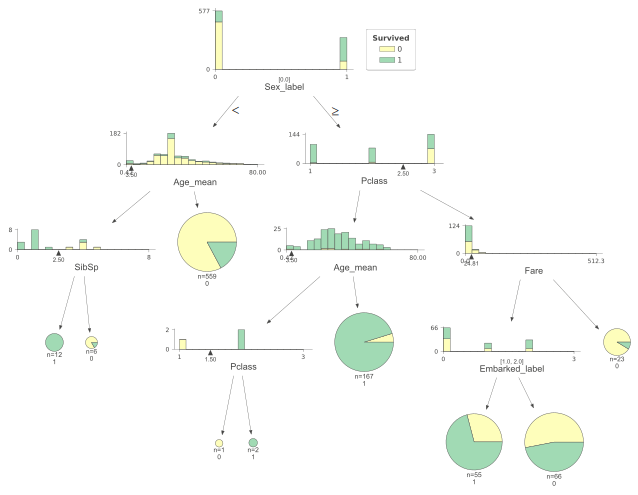

In [19]:
trees.dtreeviz(spark_dtree, fancy=True)

### viz_leaf_criterion

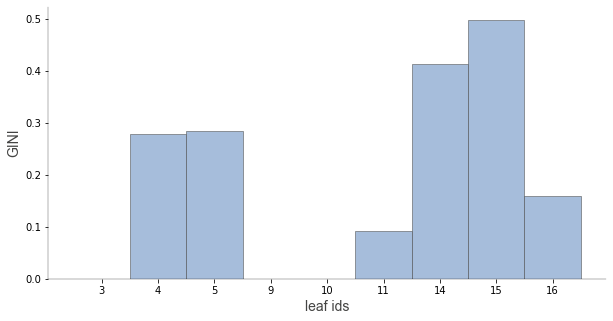

In [20]:
trees.viz_leaf_criterion(spark_dtree)

### viz_leaf_samples

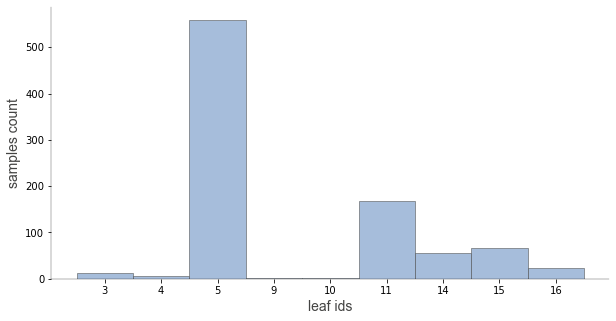

In [21]:
trees.viz_leaf_samples(spark_dtree)

### ctreeviz_leaf_samples

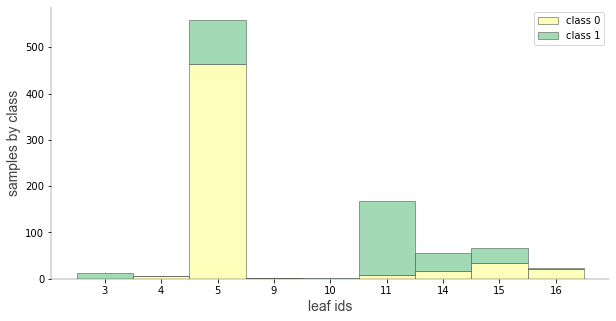

In [22]:
trees.ctreeviz_leaf_samples(spark_dtree)

### viz_leaf_criterion

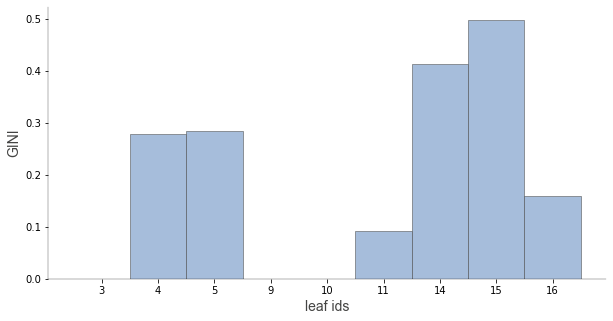

In [23]:
trees.viz_leaf_criterion(spark_dtree)

### describe_node_sample

In [24]:
trees.describe_node_sample(spark_dtree, node_id=10)

,Pclass,Sex_label,Embarked_label,Age_mean,SibSp,Parch,Fare
count,2.0,2.0,2.000000,2.000000,2.0,2.000000,2.000000
mean,2.0,1.0,0.500000,2.500000,1.0,1.500000,33.789600
std,0.0,0.0,0.707107,0.707107,0.0,0.707107,11.016158
min,2.0,1.0,0.000000,2.000000,1.0,1.000000,26.000000
25%,2.0,1.0,0.250000,2.250000,1.0,1.250000,29.894800
50%,2.0,1.0,0.500000,2.500000,1.0,1.500000,33.789600
75%,2.0,1.0,0.750000,2.750000,1.0,1.750000,37.684400
max,2.0,1.0,1.000000,3.000000,1.0,2.000000,41.579200


### explain_prediction_path

In [25]:
X = dataset[features].iloc[10]
X

Pclass             3.0
Sex_label          1.0
Embarked_label     0.0
Age_mean           4.0
SibSp              1.0
Parch              1.0
Fare              16.7
Name: 10, dtype: float64

In [26]:
print(trees.explain_prediction_path(spark_dtree, X, explanation_type="plain_english"))

2.5 <= Pclass 
Fare < 24.81
Sex_label in [1.0, 2.0] 
Embarked_label in [0.0, 3.0] 



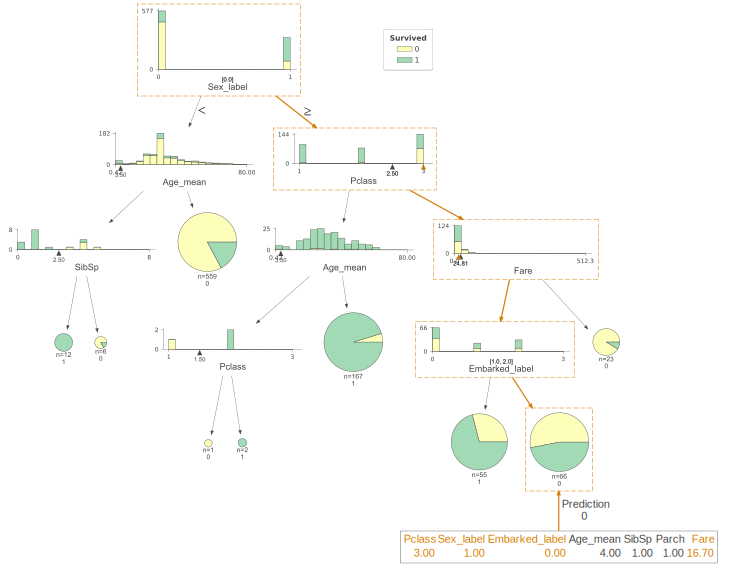

In [27]:
trees.dtreeviz(spark_dtree, X=X)

# Regression

## Prepar data and model

In [28]:
data = spark.read.csv("../data/titanic/titanic.csv", header=True, inferSchema=True)

In [29]:
features_reg = ["Pclass", "Sex_label", "Embarked_label", "Age_mean", "SibSp", "Parch", "Survived"]
target_reg = "Fare"


In [30]:
vector_assembler_reg = VectorAssembler(inputCols=features_reg, outputCol="features_reg")
decision_tree_reg = DecisionTreeRegressor(featuresCol="features_reg", labelCol=target_reg, maxDepth=3, seed=1234)
pipeline_reg = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer, vector_assembler_reg, decision_tree_reg])
model = pipeline_reg.fit(data)

In [31]:
dataset_reg = Pipeline(stages=[sex_label_indexer, embarked_label_indexer, age_imputer]) \
    .fit(data) \
    .transform(data) \
    .toPandas()[features_reg + [target_reg]]

In [32]:
dataset_reg

,Pclass,Sex_label,Embarked_label,Age_mean,SibSp,Parch,Survived,Fare
0,3,0.0,0.0,22.000000,1,0,0,7.2500
1,1,1.0,1.0,38.000000,1,0,1,71.2833
2,3,1.0,0.0,26.000000,0,0,1,7.9250
3,1,1.0,0.0,35.000000,1,0,1,53.1000
4,3,0.0,0.0,35.000000,0,0,0,8.0500
...,...,...,...,...,...,...,...,...
886,2,0.0,0.0,27.000000,0,0,0,13.0000
887,1,1.0,0.0,19.000000,0,0,1,30.0000
888,3,1.0,0.0,29.699118,1,2,0,23.4500
889,1,0.0,1.0,26.000000,0,0,1,30.0000


## dtreeviz visualisations

In [33]:
tree_model_regressor = model.stages[4]
spark_dtree_reg = ShadowSparkTree(tree_model_regressor, dataset_reg[features_reg], dataset_reg[target_reg], feature_names=features_reg, target_name=target_reg)

### dtreeviz

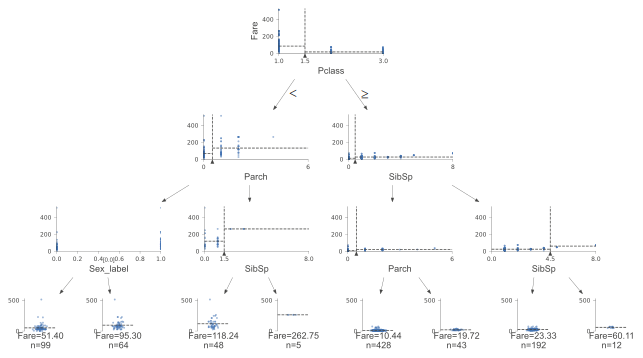

In [34]:
trees.dtreeviz(spark_dtree_reg)

### viz_leaf_samples

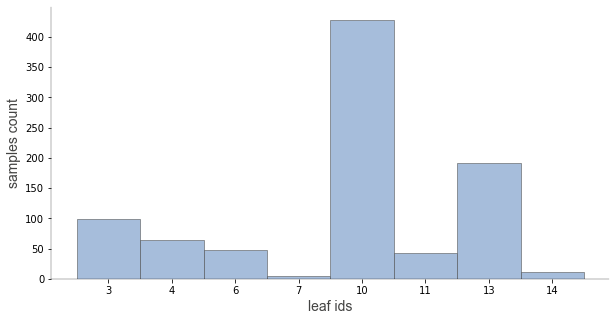

In [35]:
trees.viz_leaf_samples(spark_dtree_reg)

### viz_leaf_target

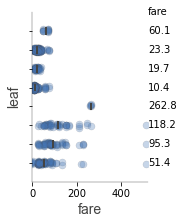

In [36]:
trees.viz_leaf_target(spark_dtree_reg)

### viz_leaf_criterion

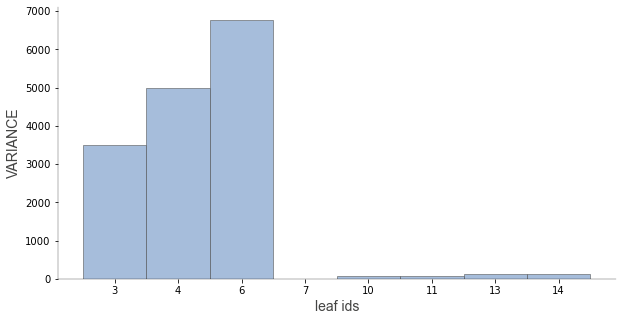

In [37]:
trees.viz_leaf_criterion(spark_dtree_reg)

### explain_prediction_path

In [38]:
X = dataset_reg[features_reg].iloc[3]
X

Pclass             1.0
Sex_label          1.0
Embarked_label     0.0
Age_mean          35.0
SibSp              1.0
Parch              0.0
Survived           1.0
Name: 3, dtype: float64

In [39]:
print(trees.explain_prediction_path(spark_dtree_reg, x = X, explanation_type="plain_english"))

Pclass < 1.5
Parch < 0.5
Sex_label in [1.0, 2.0] 



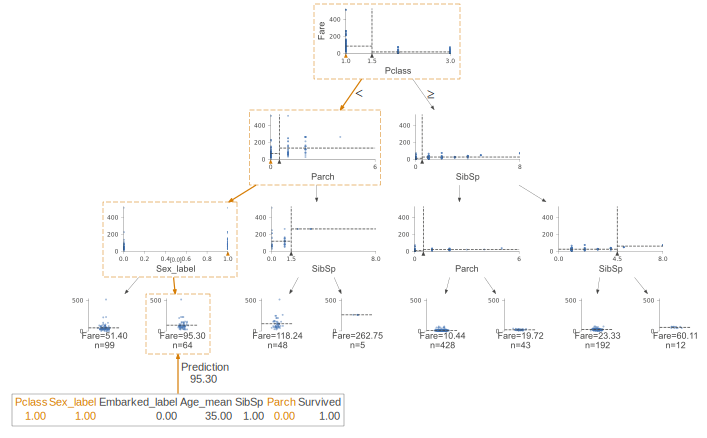

In [40]:
trees.dtreeviz(spark_dtree_reg, X=X)